## Car Price Prediction using Linear Regression Model

## 1. Introduction

Objective   : Predict car price using linear regression model.

Dataset : `Car-Price-Prediction_Dataset.csv`

Description : This dataset contains the details of used cars and their prices.

| Column | Description |
| --- | --- |
| brand | Car brand |
| model | Car model |
| year | Year of purchase |
| price | Price in GBP |
| transmission | Gearbox type |
| mileage | Mileage in Kilometers |
| fuelType | Car fuel type |
| tax | Tax per year |
| mpg | Fuel consumption (Miles per gallon) |
| engineSize | Car engine size in litres |

## 2. Import Libraries

In [1]:
# Import the libraries that will be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
import json

## 3. Data Loading

In [2]:
# Load the dataset
data = pd.read_csv('Car-Price-Prediction_Dataset.csv')
# Check the first five data from the dataset
data.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Audi,A4,2019,26695,Semi-Auto,5000,Diesel,145,51.4,2.0
1,Mercedez,C Class,2010,5999,Manual,68000,Diesel,145,56.5,2.1
2,Vauxhall,Meriva,2016,6790,Manual,27772,Petrol,145,47.1,1.4
3,VW,Shuttle,2019,28000,Semi-Auto,10074,Diesel,145,32.8,2.0
4,Vauxhall,Corsa,2017,7999,Manual,22322,Petrol,30,54.3,1.4


In [3]:
# Check the details of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         24000 non-null  object 
 1   model         24000 non-null  object 
 2   year          24000 non-null  int64  
 3   price         24000 non-null  int64  
 4   transmission  24000 non-null  object 
 5   mileage       24000 non-null  int64  
 6   fuelType      24000 non-null  object 
 7   tax           24000 non-null  int64  
 8   mpg           24000 non-null  float64
 9   engineSize    24000 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 1.8+ MB


From the description above, we can see that there are 24000 data and 10 columns in this dataset.

In [4]:
# Check if there are duplicates in the dataset
data.duplicated().sum()

143

We can see that there are 143 data duplicates in the dataset. I will drop these duplicates to make the data more consistent and avoid bias in the machine learning model.

In [5]:
# Drop data duplicates from the dataset
data.drop_duplicates(inplace=True)

In [6]:
# Check if the duplicates have successfully been dropped from the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23857 entries, 0 to 23999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         23857 non-null  object 
 1   model         23857 non-null  object 
 2   year          23857 non-null  int64  
 3   price         23857 non-null  int64  
 4   transmission  23857 non-null  object 
 5   mileage       23857 non-null  int64  
 6   fuelType      23857 non-null  object 
 7   tax           23857 non-null  int64  
 8   mpg           23857 non-null  float64
 9   engineSize    23857 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 2.0+ MB


We can see that the total data is reduced to 23857. This means that the duplicates were successfully dropped from the dataset.

In [7]:
# Check if there are data with missing value(s)
data.isna().sum()

brand           0
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

We can see that there is no data with missing value(s)

## 4. Exploratory Data Analysis

I will create a new feature called efficiency. This feature is to measure the car's efficiency based on their fuel consumption (mpg). Below are the criteria:

   * `super efficient` : `mpg` ≥ 60
   
   * `efficient` : 50 ≤ `mpg` < 60
   
   * `decent` : 35 ≤ `mpg` < 50
   
   * `standard` : 25 ≤ `mpg` < 35
   
   * `not efficient` : `mpg` < 25 

In [8]:
# Create a list to save all the values based on the criteria using loops
efficiency = []
for i in data['mpg']:
  if i >=60:
    efficiency.append('super efficient')
  elif i >=50:
    efficiency.append('efficient')
  elif i >=35:
    efficiency.append('decent')
  elif i >=25:
    efficiency.append('standard')
  elif i <25:
    efficiency.append('not efficient')
  
# Create new feature in the dataset
data['efficiency'] = efficiency

In [9]:
# Check if the feature have successfully been created.
data.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,efficiency
0,Audi,A4,2019,26695,Semi-Auto,5000,Diesel,145,51.4,2.0,efficient
1,Mercedez,C Class,2010,5999,Manual,68000,Diesel,145,56.5,2.1,efficient
2,Vauxhall,Meriva,2016,6790,Manual,27772,Petrol,145,47.1,1.4,decent
3,VW,Shuttle,2019,28000,Semi-Auto,10074,Diesel,145,32.8,2.0,standard
4,Vauxhall,Corsa,2017,7999,Manual,22322,Petrol,30,54.3,1.4,efficient


<Figure size 1200x800 with 0 Axes>

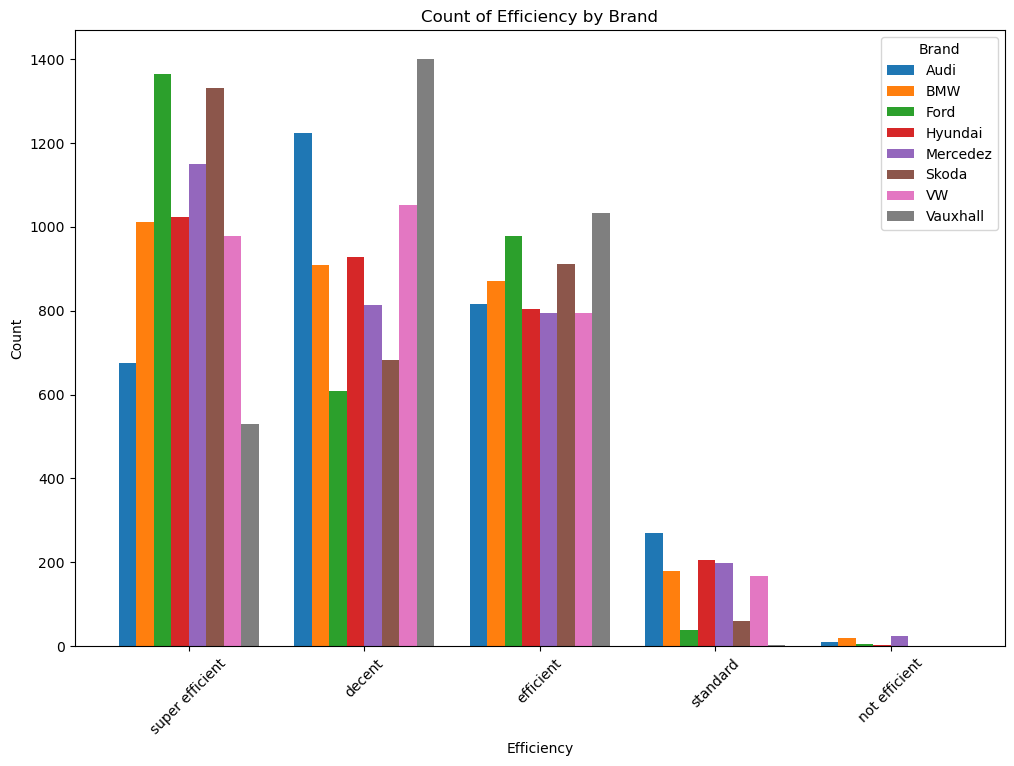

In [10]:
# Count the occurrences of each (efficiency, brand) combination
counts = data.groupby(['efficiency', 'brand']).size().unstack()

# Calculate total counts for each efficiency category and sort
efficiency_totals = counts.sum(axis=1).sort_values(ascending=False).index

# Sort the counts DataFrame based on the sorted efficiency_totals
counts_sorted = counts.loc[efficiency_totals]

# Plot clustered column chart
plt.figure(figsize=(12, 8))
counts_sorted.plot(kind='bar', figsize=(12, 8), width=0.8)

# Add labels and title
plt.xlabel('Efficiency')
plt.ylabel('Count')
plt.title('Count of Efficiency by Brand')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display legend
plt.legend(title='Brand')

# Display the plot
plt.show()

From the bar chart above, we can see that cars with super-efficient efficiency are the most common and Ford is the brand with the highest number of super-efficient cars followed by Skoda.

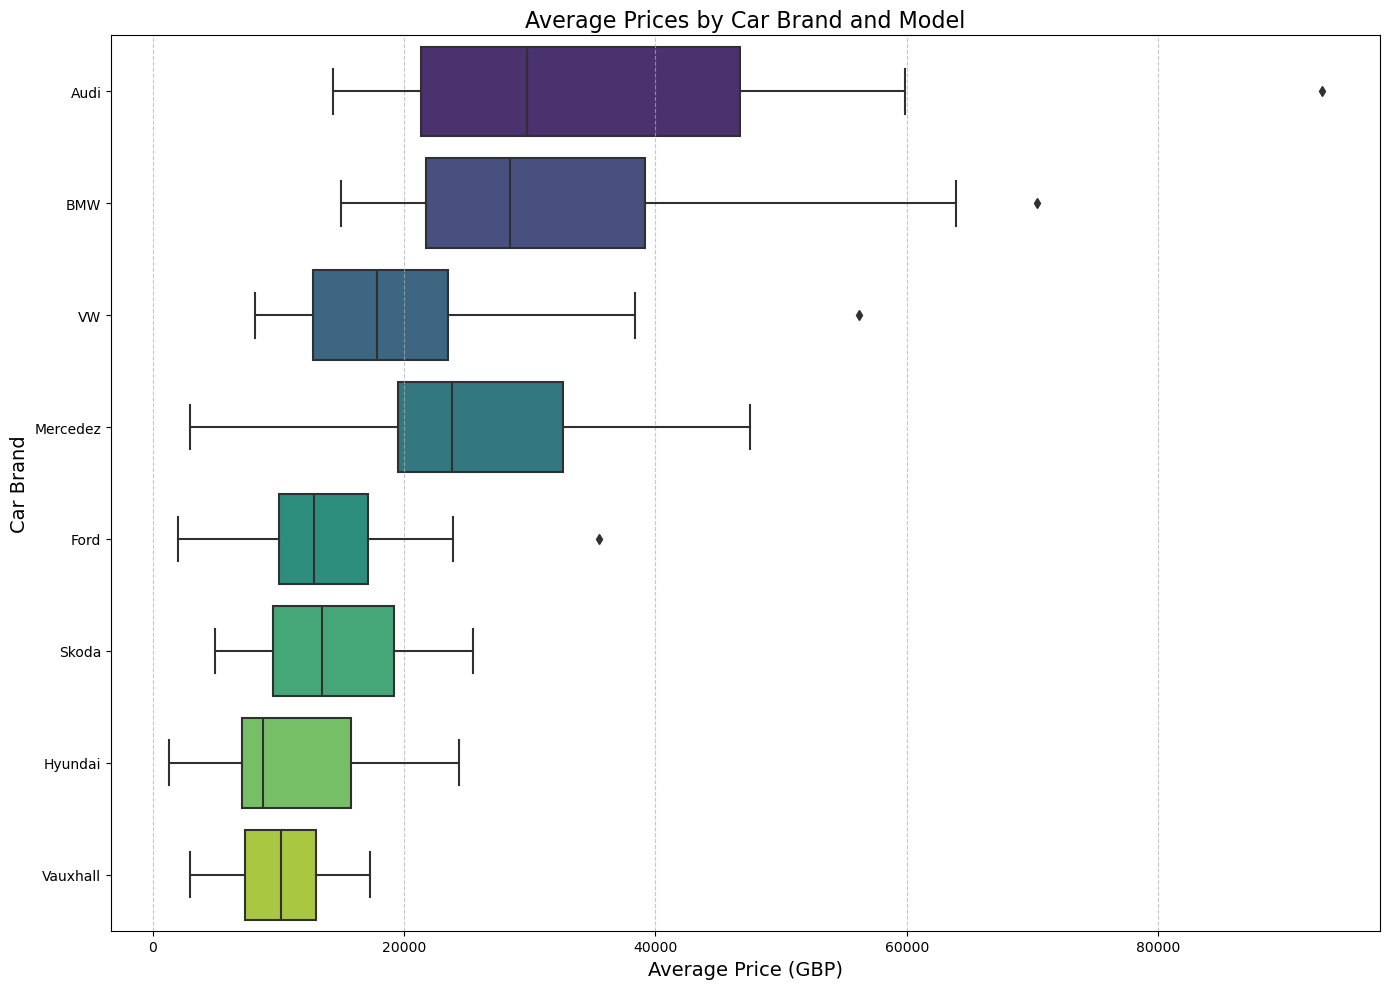

In [11]:
# Calculate average price by brand and model
average_prices = data.groupby(['brand', 'model'])['price'].mean().reset_index()

# Sort by average price descending
average_prices = average_prices.sort_values(by='price', ascending=False)

# Visualization - Box Plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='price', y='brand', data=average_prices, orient='h', palette='viridis')
plt.xlabel('Average Price (GBP)', fontsize=14)
plt.ylabel('Car Brand', fontsize=14)
plt.title('Average Prices by Car Brand and Model', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


From the box plot above, we can see that Audi has the highest average car price followed by BMW and Vauxhall has the lowest average car price followed by Hyundai.

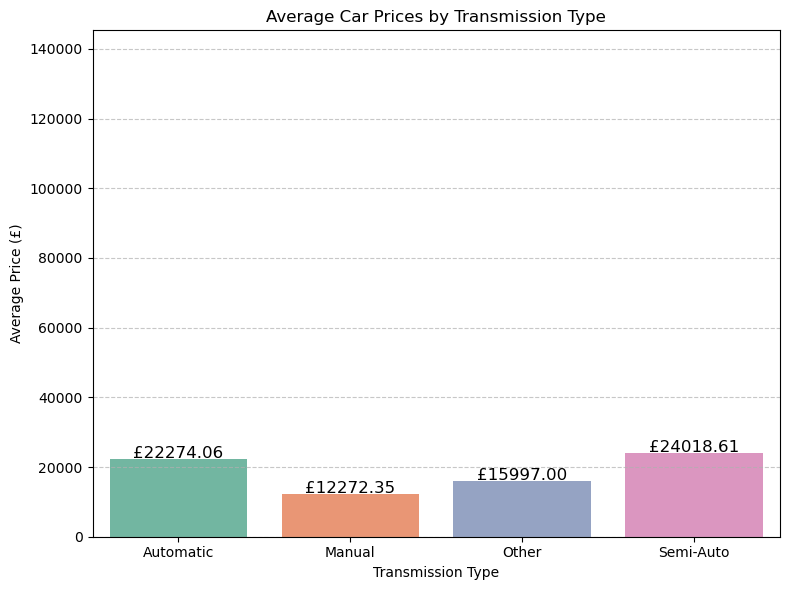

In [12]:
# Calculate average prices for manual and automatic transmission cars
avg_prices = data.groupby('transmission')['price'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='transmission', y='price', data=avg_prices, palette='Set2')
plt.title('Average Car Prices by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Average Price (£)')
plt.ylim(0, data['price'].max() + 5000)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the bars with values
for index, row in avg_prices.iterrows():
    plt.text(index, row['price'] + 200, f'£{row["price"]:.2f}', ha='center', color='black', fontsize=12)

plt.tight_layout()
plt.show()

From the bar chart above, we can see that car with semi-auto transmission tend to have higher prices and car with manual transmission tend to have lower price.

## 5. Feature Engineering

### Cardinality check

In [13]:
# Check any categorical columns (object)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23857 entries, 0 to 23999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         23857 non-null  object 
 1   model         23857 non-null  object 
 2   year          23857 non-null  int64  
 3   price         23857 non-null  int64  
 4   transmission  23857 non-null  object 
 5   mileage       23857 non-null  int64  
 6   fuelType      23857 non-null  object 
 7   tax           23857 non-null  int64  
 8   mpg           23857 non-null  float64
 9   engineSize    23857 non-null  float64
 10  efficiency    23857 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 2.2+ MB


In [14]:
# Check if there are categorical columns with high cardinality
print(data.brand.nunique())
print(data.model.nunique())
print(data.transmission.nunique())
print(data.fuelType.nunique())
print(data.efficiency.nunique())

8
163
4
5
5


We can see that model column has high cardinality. Columns with high cardinality tend to make machine learning models overfit and may cause our dataset to have high dimensionality when encoding. For those reasons I will drop model column.

In [15]:
# Drop the model column from the dataset
data.drop('model', axis=1, inplace=True)

In [16]:
# Check if the model column have successfully been dropped from the dataset
data.head()

,brand,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,efficiency
0,Audi,2019,26695,Semi-Auto,5000,Diesel,145,51.4,2.0,efficient
1,Mercedez,2010,5999,Manual,68000,Diesel,145,56.5,2.1,efficient
2,Vauxhall,2016,6790,Manual,27772,Petrol,145,47.1,1.4,decent
3,VW,2019,28000,Semi-Auto,10074,Diesel,145,32.8,2.0,standard
4,Vauxhall,2017,7999,Manual,22322,Petrol,30,54.3,1.4,efficient


### Split dataset

In [17]:
# Splitting the dataset into features(X) and targets(y)
X = data.drop('price', axis=1)
y = data['price']

# Splitting X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 4)

# Check the train and test distribution 
print('X Train size : ', X_train.shape)
print('X Test size : ', X_test.shape)
print('Y Train size : ', y_train.shape)
print('Y Test size : ', y_test.shape)

X Train size :  (19085, 9)
X Test size :  (4772, 9)
Y Train size :  (19085,)
Y Test size :  (4772,)


### Split numerical columns and categorical columns

In [18]:
# Create a list to save all the column according to their type
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=object).columns.tolist()

print(f'Numerical columns   : {num_cols}')
print(f'Categorical columns : {cat_cols}')

Numerical columns   : ['year', 'mileage', 'tax', 'mpg', 'engineSize']
Categorical columns : ['brand', 'transmission', 'fuelType', 'efficiency']


In [19]:
# Splitting train and test based on their type
X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]
X_train_cat = X_train[cat_cols]
X_test_cat = X_test[cat_cols]

X_train_cat

,brand,transmission,fuelType,efficiency
3955,BMW,Semi-Auto,Hybrid,efficient
18696,Hyundai,Manual,Petrol,decent
9860,VW,Manual,Diesel,efficient
8636,Ford,Manual,Petrol,efficient
23458,Ford,Manual,Diesel,super efficient
...,...,...,...,...
11916,Hyundai,Manual,Diesel,efficient
22530,VW,Automatic,Petrol,decent
17180,Audi,Semi-Auto,Petrol,decent
8400,Ford,Automatic,Diesel,efficient


### Outliers Handling

In [20]:
# Create skewed and normal list to save column according to their skewness
skewed = []
normal = []
# Display skew value from each numerical column using looping
for i in X_train_num.columns.to_list():
    print(f'Column {i} skewness value: {X_train_num[i].skew()}')
    # Append numerical column to list based on their skewness value
    if X_train_num[i].nunique()>10:
        if X_train_num[i].skew() > -0.5 and X_train_num[i].skew() < 0.5:
            normal.append(i)
        else:
            skewed.append(i)
    print('-'*80)

# Display numerical columns according to their distribution
print('Column with skew distribution: ', skewed)
print('Column with normal distribution: ', normal)

Column year skewness value: -1.6469488525371792
--------------------------------------------------------------------------------
Column mileage skewness value: 1.7615862340127648
--------------------------------------------------------------------------------
Column tax skewness value: -0.08552629304599768
--------------------------------------------------------------------------------
Column mpg skewness value: 9.64085740738366
--------------------------------------------------------------------------------
Column engineSize skewness value: 1.237479972604401
--------------------------------------------------------------------------------
Column with skew distribution:  ['year', 'mileage', 'mpg', 'engineSize']
Column with normal distribution:  ['tax']


We can see that there are quite a lot of columns with a skew distribution. I will use the capping method in handling outliers because if I do triming method, a lot of data will be deleted because there are many columns with a skew distribution.

In [21]:
# Outliers handling using capping method with winsorizer library
winsorizer_skewed = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=skewed)
winsorizer_normal = Winsorizer(capping_method='gaussian',
                             tail='both',
                             fold=3,
                             variables=normal)
X_train_capped = winsorizer_skewed.fit_transform(X_train_num)
X_test_capped = winsorizer_skewed.transform(X_test_num)
X_train_capped = winsorizer_normal.fit_transform(X_train_capped)
X_test_capped = winsorizer_normal.transform(X_test_capped)
X_train_capped.head()

,year,mileage,tax,mpg,engineSize
3955,2020.0,8,145.0,52.3,2.0
18696,2018.0,8795,145.0,44.1,1.0
9860,2017.0,70074,150.0,58.9,2.0
8636,2019.0,2554,145.0,56.5,1.0
23458,2018.0,30000,145.0,64.2,1.5


mpg column before capping


c:\Users\asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


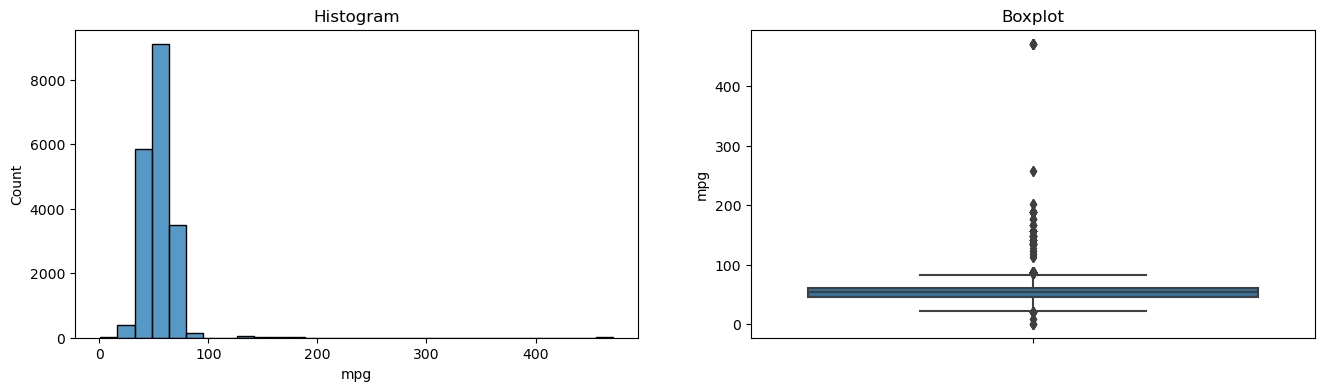


 mpg column after capping


c:\Users\asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


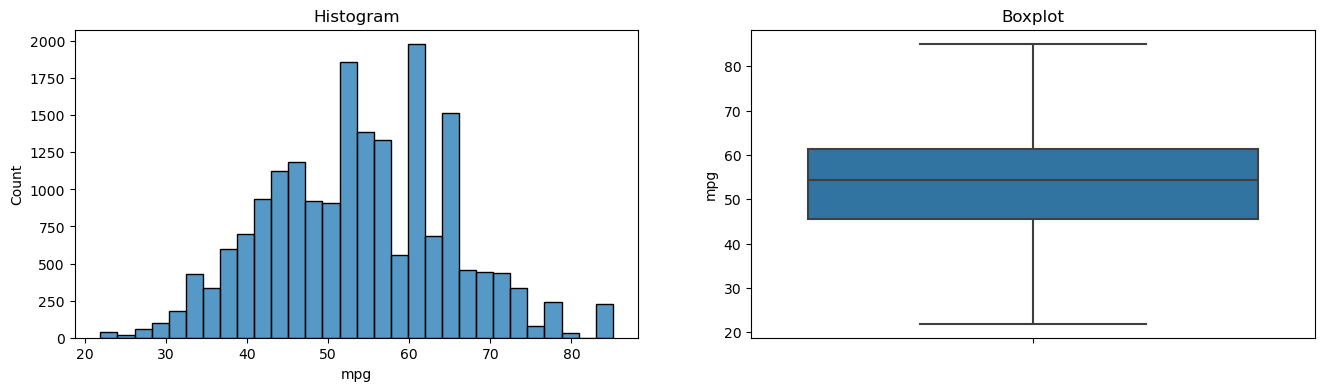

In [22]:
# Create a function to display histogram and boxplot from column
def outliers_plots(data, variable):    
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable], bins=30)
    plt.title('Histogram')
    plt.subplot(1, 2, 2)
    sns.boxplot(y=data[variable])
    plt.title('Boxplot')
    plt.show()

# Check the histogram and boxplot from mpg column (skewed distribution)
print('mpg column before capping')
outliers_plots(X_train_num, 'mpg')
print('\n mpg column after capping')
outliers_plots(X_train_capped, 'mpg')

### Feature Scaling and Encoding

Feature scaling is used to normalize the range of values of independent variables. In other words, Feature Scaling is methods to set the range of feature values within a similar scale. I will use Standard Scaler because regression requires standardized features. 

Feature encoding is the process of converting categorical or non-numeric features into a numerical format that can be used as input for machine learning algorithms. I will use One Hot Encoder because all of the categorical columns are nominal categorical features.

In [23]:
# Feature scaling using Standard Scaler
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_capped)
X_test_num_scaled = scaler.transform(X_test_capped)
columnNames = scaler.get_feature_names_out()

X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=columnNames)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=columnNames)
X_train_num_scaled

,year,mileage,tax,mpg,engineSize
0,1.502848,-1.192048,0.391871,-0.143474,0.666508
1,0.428802,-0.717901,0.391871,-0.869482,-1.326145
2,-0.108221,2.588712,0.477519,0.440875,0.666508
3,0.965825,-1.054666,0.391871,0.228384,-1.326145
4,0.428802,0.426320,0.391871,0.910124,-0.329819
...,...,...,...,...,...
19080,-0.108221,-0.399753,0.391871,0.033602,0.666508
19081,1.502848,-1.009663,0.391871,-0.674699,-1.326145
19082,0.965825,-0.841686,0.477519,-1.152802,0.666508
19083,-0.645243,-0.473463,-1.578023,0.440875,-0.329819


In [24]:
# Feature encoding using One Hot Encoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_cat_encoded = encoder.fit_transform(X_train_cat).toarray()
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()
columnNames2 = encoder.get_feature_names_out()

X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns = columnNames2)
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns = columnNames2)
X_train_cat_encoded

,brand_Audi,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedez,brand_Skoda,brand_VW,brand_Vauxhall,transmission_Automatic,transmission_Manual,...,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,efficiency_decent,efficiency_efficient,efficiency_not efficient,efficiency_standard,efficiency_super efficient
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19080,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19081,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
19082,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
19083,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Concatenate Data

In [25]:
# Reunite numerical and categorical columns
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_encoded], axis = 1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded], axis = 1)
X_train_final = pd.DataFrame(X_train_final)
X_test_final = pd.DataFrame(X_test_final)
X_train_final

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.502848,-1.192048,0.391871,-0.143474,0.666508,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.428802,-0.717901,0.391871,-0.869482,-1.326145,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.108221,2.588712,0.477519,0.440875,0.666508,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.965825,-1.054666,0.391871,0.228384,-1.326145,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.428802,0.426320,0.391871,0.910124,-0.329819,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19080,-0.108221,-0.399753,0.391871,0.033602,0.666508,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19081,1.502848,-1.009663,0.391871,-0.674699,-1.326145,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
19082,0.965825,-0.841686,0.477519,-1.152802,0.666508,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
19083,-0.645243,-0.473463,-1.578023,0.440875,-0.329819,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 6. Model Definition

I will use Linear Regression with Lasso Regularization. Regularization is used to avoid overfitting issue. 

Lasso stop overfitting by including a penalty term in the cost function. The model is penalized for the sum of absolute values of its weights.

In [26]:
# Define Lasso Linear Regression Model
lasso_lin_reg = Lasso(alpha=1)

## 7. Model Training

In [27]:
# Train Lasso Linear Regression Model 
lasso_lin_reg.fit(X_train_final, y_train)

Lasso(alpha=1)

## 8. Model Evaluation

I will use Mean Absolute Error (MAE) and R2 Score as the cost functions. 

MAE displays the average absolute distance between the actual and predicted value. 

R2 Score displays how well the predictor variables can explain the variation in the response variable. 

In [28]:
y_pred_train = lasso_lin_reg.predict(X_train_final)
y_pred_test = lasso_lin_reg.predict(X_test_final)

In [29]:
print('MAE - Train Set  : ', mean_absolute_error(y_train, y_pred_train))
print('MAE - Test Set   : ', mean_absolute_error(y_test, y_pred_test))
print('')

print('R2 Score - Train Set : ', r2_score(y_train, y_pred_train))
print('R2 Score - Test Set  : ', r2_score(y_test, y_pred_test))
print('')

MAE - Train Set  :  2792.635094281562
MAE - Test Set   :  2767.2310956000592

R2 Score - Train Set :  0.7951508511386887
R2 Score - Test Set  :  0.808202987249493



From the information above, we can see that although the R2 Score indicate that the model is a good fit, the MAE score is still very high. MAE of 2767 indicates that, on average, the model's predictions deviate from the actual prices by 2767. For predicting expensive luxury cars, this might be considered reasonable prediction error, but for predicting budget-friendly cars it would be a significant error.

In [30]:
print("The maximum value of y_train is", y_train.max())
print("The maximum value of y_pred_train is", y_pred_train.max())
print("The minimum value of y_train is", y_train.min())
print("The minimum value of y_pred_train is", y_pred_train.min())
print("")

print("The maximum value of y_test is", y_test.max())
print("The maximum value of y_pred_test is", y_pred_test.max())
print("The minimum value of y_test is", y_test.min())
print("The minimum value of y_pred_test is", y_pred_test.min())

The maximum value of y_train is 140319
The maximum value of y_pred_train is 66237.0246833537
The minimum value of y_train is 495
The minimum value of y_pred_train is -7026.590211098261

The maximum value of y_test is 129990
The maximum value of y_pred_test is 65298.39048848588
The minimum value of y_test is 1295
The minimum value of y_pred_test is -5919.296980622468


From the information above, we can see that the maximum and minimum values of training and test prediction are significantly lower than the actual values. The model also predicted negative value, which suggests there might be issues with the model. We can conclude that the model cannot predict cars with very high and low price accurately.

In [31]:
dftrain = pd.DataFrame({'Actual Price': y_train, 'Predicted Price': y_pred_train})
dftrain.sample(10)

,Actual Price,Predicted Price
10664,54990,36390.555140
23001,14500,12411.865961
20098,8490,8762.310153
2593,12000,15337.559074
21019,24990,23046.276912
22859,28980,29200.999664
8043,21400,25626.588852
18888,11399,10278.749709
12756,19895,23692.993208
757,10990,13215.009136


In [32]:
dftest = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred_test})
dftest.sample(10)

,Actual Price,Predicted Price
8014,12520,15020.909667
15253,18790,20926.593006
8955,14990,15420.207182
6438,31795,36573.860009
19634,22499,19643.175949
16826,9999,12693.788407
20853,52950,42642.250385
9297,23490,28472.240679
17556,27995,26785.310136
12112,7495,8624.218157


From the information above, we can see that the model tends to predict values higher than the actual values for both training and test sets.

## 9. Model Saving

I will save the necessary files and model to predict new car data.

In [33]:
# Save the necessary files and model
with open('list_num_cols.txt', 'w') as file_1:
  json.dump(num_cols, file_1)

with open('list_cat_cols.txt', 'w') as file_2:
  json.dump(cat_cols, file_2)

with open('model_scaler.pkl', 'wb') as file_3:
  pickle.dump(scaler, file_3)

with open('model_encoder.pkl', 'wb') as file_4:
  pickle.dump(encoder, file_4)

with open('lasso_lin_reg.pkl', 'wb') as file_5:
  pickle.dump(lasso_lin_reg, file_5)

## 11. Conclusion

The model successfully predicts new car data from model inference, but there are many aspects that still need improvement, such as making the MAE score lower and addressing negative prediction issues. The model can be improved in various ways, including:
- More feature engineering technique such as creating new features from existing features
- Feature selection by choosing only the most relevant features 
- Using a different regression model such as polynomial